In [1]:
import numpy as np
import pandas as pd
import os
import re
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.size'] = 16

In [2]:
!pip install kaggle

In [3]:
import os
os.makedirs('/root/.kaggle', exist_ok=True)
!cp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [5]:
!kaggle datasets download -d paramaggarwal/fashion-product-images-dataset --unzip

Dataset URL: https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-dataset
License(s): MIT
100% 23.1G/23.1G [12:20<00:00, 33.7MB/s]
100% 23.1G/23.1G [12:20<00:00, 33.5MB/s]


In [7]:
img_path = '/content/fashion-dataset/images'
img_df = pd.read_csv('images.csv')
styles_df = pd.read_csv('styles.csv', on_bad_lines='warn')

<ipython-input-7-f5b51e17c7ba>:3: ParserWarning: Skipping line 6044: expected 10 fields, saw 11
Skipping line 6569: expected 10 fields, saw 11
Skipping line 7399: expected 10 fields, saw 11
Skipping line 7939: expected 10 fields, saw 11
Skipping line 9026: expected 10 fields, saw 11
Skipping line 10264: expected 10 fields, saw 11
Skipping line 10427: expected 10 fields, saw 11
Skipping line 10905: expected 10 fields, saw 11
Skipping line 11373: expected 10 fields, saw 11
Skipping line 11945: expected 10 fields, saw 11
Skipping line 14112: expected 10 fields, saw 11
Skipping line 14532: expected 10 fields, saw 11
Skipping line 15076: expected 10 fields, saw 12
Skipping line 29906: expected 10 fields, saw 11
Skipping line 31625: expected 10 fields, saw 11
Skipping line 33020: expected 10 fields, saw 11
Skipping line 35748: expected 10 fields, saw 11
Skipping line 35962: expected 10 fields, saw 11
Skipping line 37770: expected 10 fields, saw 11
Skipping line 38105: expected 10 fields, saw

In [8]:
img_df.head()

,filename,link
0,15970.jpg,http://assets.myntassets.com/v1/images/style/p...
1,39386.jpg,http://assets.myntassets.com/v1/images/style/p...
2,59263.jpg,http://assets.myntassets.com/v1/images/style/p...
3,21379.jpg,http://assets.myntassets.com/v1/images/style/p...
4,53759.jpg,http://assets.myntassets.com/v1/images/style/p...


In [9]:
styles_df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [10]:
styles_df['filename'] = styles_df['id'].astype(str) + '.jpg'

In [11]:
styles_df

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,filename
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,53759.jpg
...,...,...,...,...,...,...,...,...,...,...,...
44419,17036,Men,Footwear,Shoes,Casual Shoes,White,Summer,2013.0,Casual,Gas Men Caddy Casual Shoe,17036.jpg
44420,6461,Men,Footwear,Flip Flops,Flip Flops,Red,Summer,2011.0,Casual,Lotto Men's Soccer Track Flip Flop,6461.jpg
44421,18842,Men,Apparel,Topwear,Tshirts,Blue,Fall,2011.0,Casual,Puma Men Graphic Stellar Blue Tshirt,18842.jpg
44422,46694,Women,Personal Care,Fragrance,Perfume and Body Mist,Blue,Spring,2017.0,Casual,Rasasi Women Blue Lady Perfume,46694.jpg


In [12]:
import os

if os.path.exists(img_path):
    img_files = os.listdir(img_path)
    print(f"Total images found: {len(img_files)}")
else:
    print("Image path does not exist. Please check the path.")

Total images found: 44441


In [18]:
def demand_analysis(df):
    """
    This function performs a demand analysis on the provided dataframe.

    Args:
        df (pd.DataFrame): The dataframe to analyze.

    Returns:
        None: Prints the analysis results.
    """
    # Example analysis: Print the most frequent categories.
    print("Most frequent categories:")
    print(df['masterCategory'].value_counts().head(10))

# ... (Rest of your code) ...
demand_analysis(styles_df)

Most frequent categories:
masterCategory
Apparel           21397
Accessories       11274
Footwear           9219
Personal Care      2403
Free Items          105
Sporting Goods       25
Home                  1
Name: count, dtype: int64


<ipython-input-22-bda79a55c326>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=demand_counts.index, y=demand_counts.values, palette="rocket")


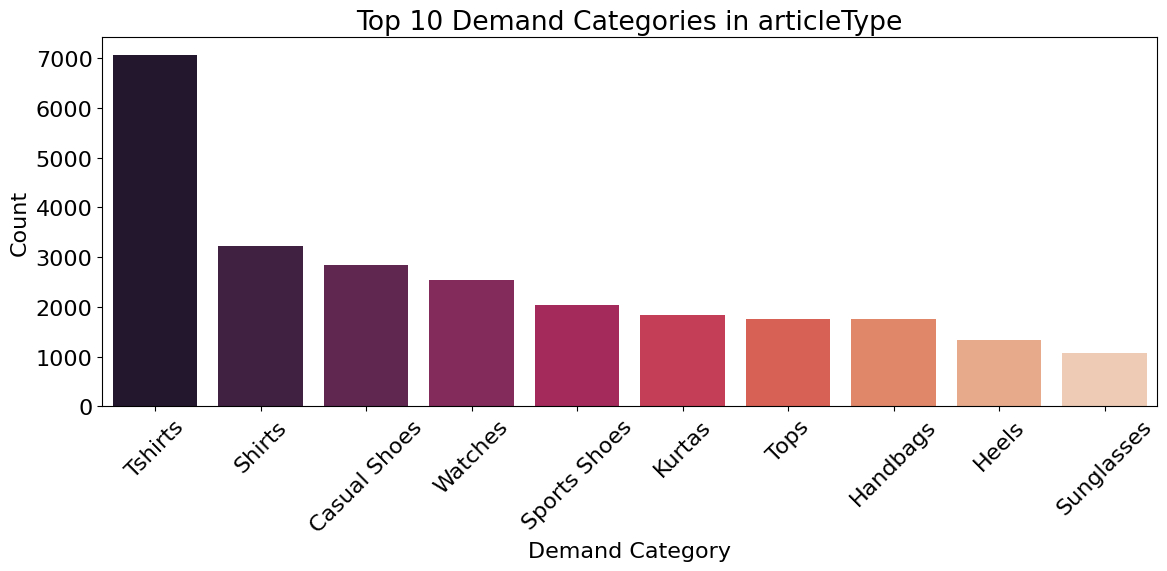

In [22]:
def demand_analysis(dataframe, demand_column, top_n=10):
    """
    Displays a bar graph or time-series analysis to visualize demand trends.

    Parameters:
    - dataframe: The pandas DataFrame containing the data.
    - demand_column: The column to analyze for demand (e.g., 'articleType' or 'season').
    - top_n: The number of top items to display in the demand graph.
    """
    if demand_column not in dataframe.columns:
        raise ValueError(f"Column '{demand_column}' not found in the dataframe.")

    # Calculate the top N items based on demand
    demand_counts = dataframe[demand_column].value_counts().head(top_n)

    # Plot the graph
    plt.figure(figsize=(12, 6))
    sns.barplot(x=demand_counts.index, y=demand_counts.values, palette="rocket")
    plt.xlabel('Demand Category')
    plt.ylabel('Count')
    plt.title(f'Top {top_n} Demand Categories in {demand_column}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example usage
demand_analysis(styles_df, demand_column='articleType', top_n=10)


In [20]:
def segmentation_analysis(df):
    """
    This function performs a segmentation analysis on the provided dataframe.

    Args:
        df (pd.DataFrame): The dataframe to analyze.

    Returns:
        None: Prints the analysis results.
    """
    # Example analysis: Print the most frequent subcategories.
    print("Most frequent subcategories:")
    print(df['subCategory'].value_counts().head(10))


# Call the function after defining it.
segmentation_analysis(styles_df)

Most frequent subcategories:
subCategory
Topwear       15402
Shoes          7343
Bags           3055
Bottomwear     2694
Watches        2542
Innerwear      1808
Jewellery      1079
Eyewear        1073
Fragrance      1011
Sandal          963
Name: count, dtype: int64


<ipython-input-21-51050ddde8ef>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=segment_counts.index, y=segment_counts.values, palette="viridis")


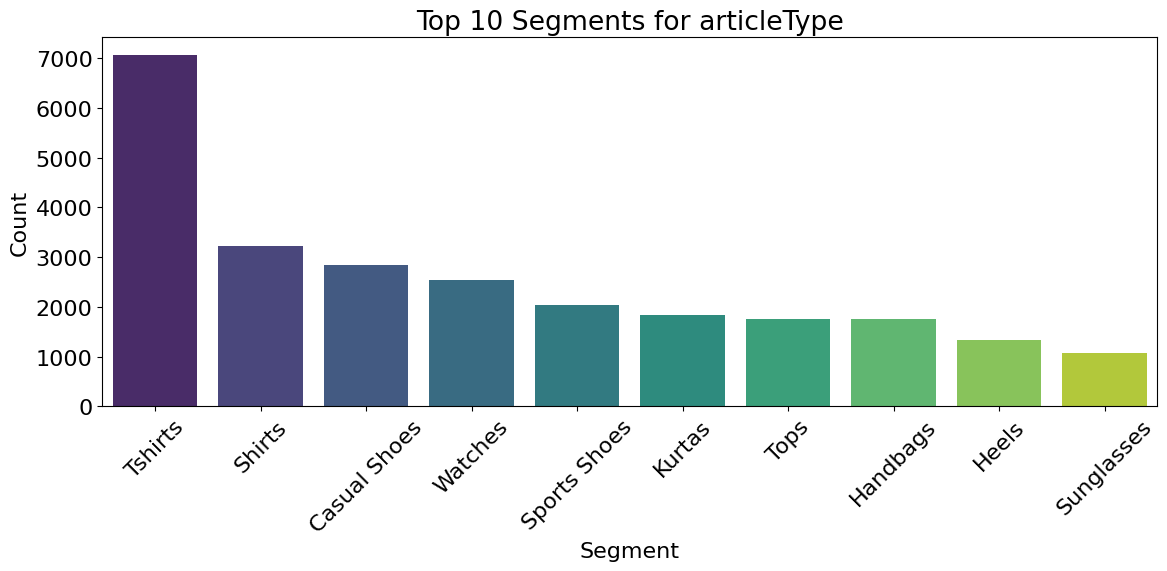

In [21]:
def segmentation_analysis(dataframe, segment_column, top_n=10):
    """
    Displays a bar graph showing the top N segments based on the given column.

    Parameters:
    - dataframe: The pandas DataFrame containing the data.
    - segment_column: The column to analyze for segmentation.
    - top_n: The number of top segments to display.
    """
    if segment_column not in dataframe.columns:
        raise ValueError(f"Column '{segment_column}' not found in the dataframe.")

    # Calculate the value counts
    segment_counts = dataframe[segment_column].value_counts().head(top_n)

    # Plot the graph
    plt.figure(figsize=(12, 6))
    sns.barplot(x=segment_counts.index, y=segment_counts.values, palette="viridis")
    plt.xlabel('Segment')
    plt.ylabel('Count')
    plt.title(f'Top {top_n} Segments for {segment_column}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example usage
segmentation_analysis(styles_df, segment_column='articleType', top_n=10)


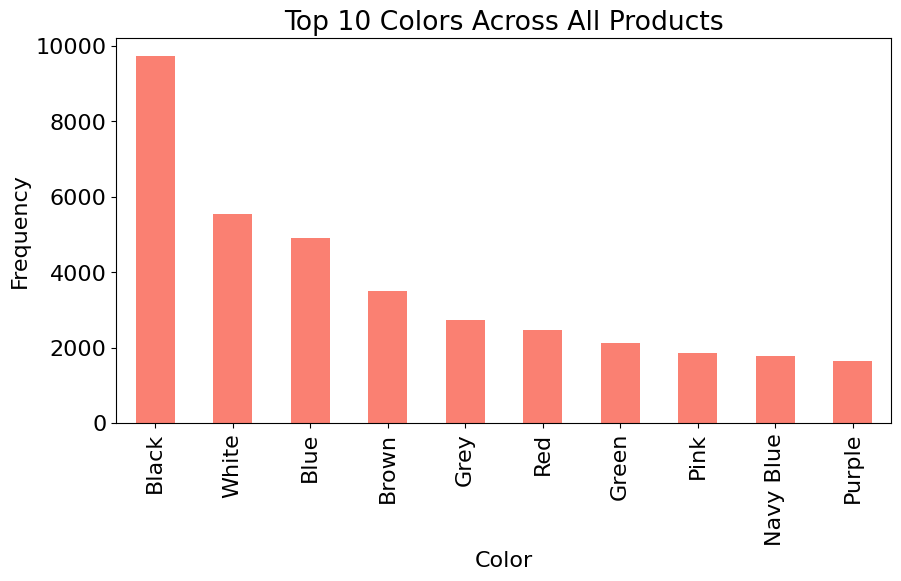

In [23]:
color_counts = styles_df['baseColour'].value_counts().head(10)
plt.figure(figsize=(10, 5))
color_counts.plot(kind='bar', color='salmon')
plt.title('Top 10 Colors Across All Products')
plt.xlabel('Color')
plt.ylabel('Frequency')
plt.show()

<ipython-input-24-0764659cd702>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_product_types = season_product_count.groupby('season').apply(lambda x: x.nlargest(10, 'count')).reset_index(drop=True)


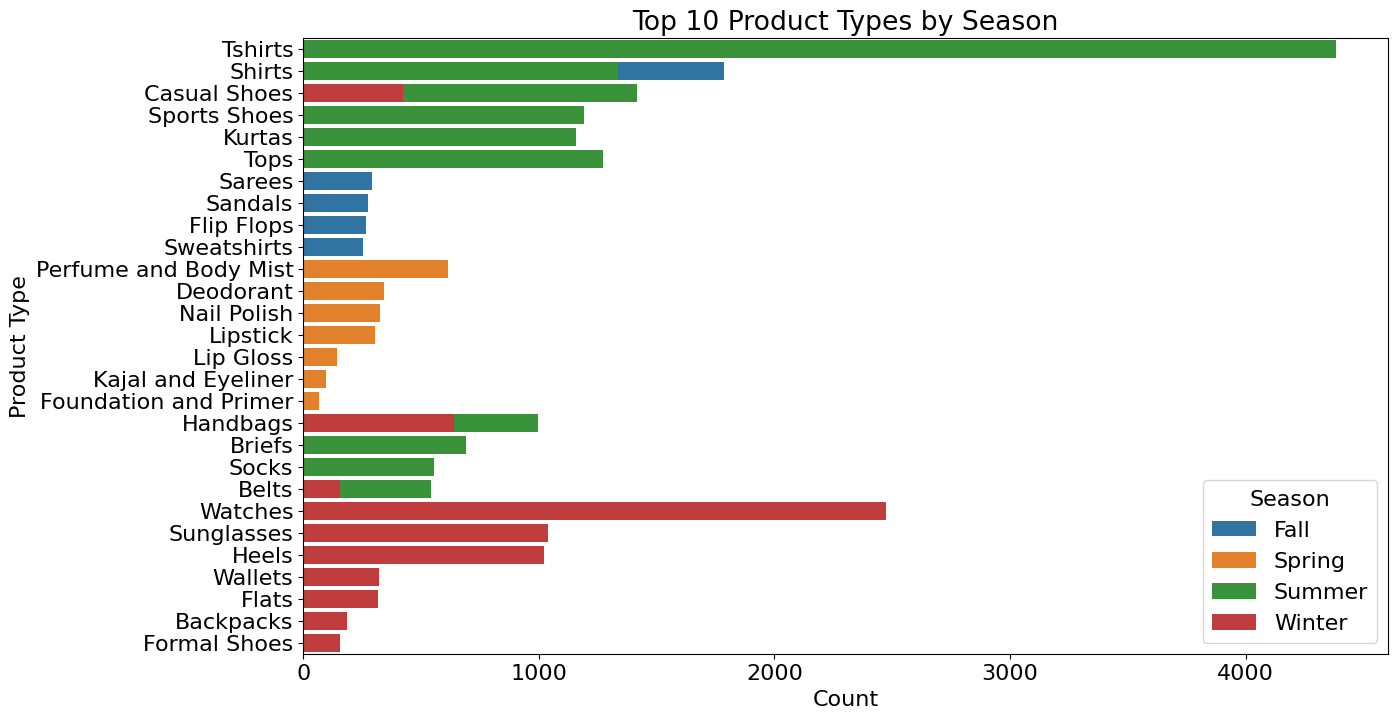

In [24]:
# Group by season and product type to count occurrences
season_product_count = styles_df.groupby(['season', 'articleType']).size().reset_index(name='count')

# Get top 10 product types for each season
top_product_types = season_product_count.groupby('season').apply(lambda x: x.nlargest(10, 'count')).reset_index(drop=True)

plt.figure(figsize=(14, 8))
sns.barplot(data=top_product_types, x='count', y='articleType', hue='season', dodge=False)
plt.title('Top 10 Product Types by Season')
plt.xlabel('Count')
plt.ylabel('Product Type')
plt.legend(title='Season')
plt.show()